# 일상대화 말뭉치 Corpus

In [376]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import seaborn as sns

## 분석 대상 정의

In [377]:
# 자음
consonant = ['ㅂ', 'ㅍ', 'ㅅ', 'ㅁ', 'ㄴ']
# target 모음
target_vowel = ['ㅏ', 'ㅐ', 'ㅣ', 'ㅗ', 'ㅜ']

## 파일 로드

In [378]:
corpus1Path = "./word_frequency.csv"
corpus2Path = "./Korean Language Usage Frequency Study/일반어휘통계.xlsx"
# 약 360만 어절.
corpus1 = pd.read_csv(corpus1Path)
# 약 300만 어절.
corpus2 = pd.read_excel(corpus2Path)
corpus1.shape, corpus2.shape

((71698, 2), (82501, 5))

In [379]:
# 저빈도 순으로 정렬.

corpus1.sort_values(by='빈도', ascending=True, inplace=True, ignore_index=True)
corpus1

,단어,빈도
0,나대진가,1
1,담갔어요,1
2,들어가겠네,1
3,들어오겠지,1
4,보러도,1
...,...,...
71693,사람,18997
71694,하는,23080
71695,가지,25581
71696,생각,33607


In [380]:
corpus2.sort_values(by='빈도', ascending=False, inplace=True, ignore_index=True)
corpus2

,순위,빈도,어휘,풀이,품사
0,1,97499,이다,NaN,지
1,2,50558,것01,NaN,의
2,3,42900,하다01,NaN,동
3,4,39290,있다01,NaN,보
4,5,37028,있다01,NaN,형
...,...,...,...,...,...
82496,1171,1,전사되다01,傳寫-,동
82497,1171,1,부책임자,副責任者,명
82498,1171,1,부처,NaN,명
82499,1171,1,전사14,傳寫,명


## Utils

In [381]:
def extract_korean(text):
    # 한글 정규표현식 패턴
    # ㄱ-ㅎ: 자음, ㅏ-ㅣ: 모음, 가-힣: 완성된 한글 글자
    pattern = '[ㄱ-ㅎㅏ-ㅣ가-힣]+'
    
    # 한글만 추출
    result = re.findall(pattern, text)
    
    # 결과를 하나의 문자열로 합치기
    return ''.join(result)


def syllable_count(df: pd.DataFrame, col_name: str):
    
    if df.columns.__contains__(col_name):
        df['음절수'] = df[col_name].str.len()
        df = df[df['음절수'] == 2]
        df.reset_index(drop=True, inplace=True)
    else:
        raise ValueError(f"col_name: {col_name} not found in df")
    
    return df

In [382]:
def decompose_hangul_phoneme(text):
    # 초성 리스트
    CHOSUNG = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
    # 중성 리스트
    JUNGSUNG = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
    # 종성 리스트 (공백은 종성 없음을 의미)
    JONGSUNG = ['', 'ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']

    chosung_list = []
    jungsung_list = []
    jongsung_list = []
    for char in text:
        # 한글인 경우만 분해
        if '가' <= char <= '힣':
            # 유니코드 값에서 한글 시작 값(0xAC00) 빼기
            char_code = ord(char) - 0xAC00
            
            # 초성 인덱스 = 문자코드 // (중성 개수 * 종성 개수)
            cho_idx = char_code // (21 * 28)
            # 중성 인덱스 = (문자코드 % (중성 개수 * 종성 개수)) // 종성 개수
            jung_idx = (char_code % (21 * 28)) // 28
            # 종성 인덱스 = 문자코드 % 종성 개수
            jong_idx = char_code % 28
            
            chosung_list.append(CHOSUNG[cho_idx])
            jungsung_list.append(JUNGSUNG[jung_idx])
            if jong_idx > 0:  # 종성이 있는 경우만 추가
                jongsung_list.append(JONGSUNG[jong_idx])
        else:
            pass
    
    return chosung_list, jungsung_list, jongsung_list

In [383]:
def set_2_syllable(df: pd.DataFrame):
    df = df[df['음절수'] == 2]
    df.reset_index(drop=True, inplace=True)
    return df

In [384]:
# 사용 예시
word_sample = "안녕하세요"
chosung_list, jungsung_list, jongsung_list = decompose_hangul_phoneme(word_sample)
print(f"원본 단어: {word_sample}")
print(f"분해 결과: {chosung_list, jungsung_list, jongsung_list}")

원본 단어: 안녕하세요
분해 결과: (['ㅇ', 'ㄴ', 'ㅎ', 'ㅅ', 'ㅇ'], ['ㅏ', 'ㅕ', 'ㅏ', 'ㅔ', 'ㅛ'], ['ㄴ', 'ㅇ'])


## Preprocessing

### 일반어휘 통계 중복어 합치기

In [385]:
# 필요없는 컬럼 제거
if corpus2.columns.__contains__('순위') and corpus2.columns.__contains__('풀이'):
    corpus2.drop(columns=['순위', '풀이'], inplace=True)
corpus2

,빈도,어휘,품사
0,97499,이다,지
1,50558,것01,의
2,42900,하다01,동
3,39290,있다01,보
4,37028,있다01,형
...,...,...,...
82496,1,전사되다01,동
82497,1,부책임자,명
82498,1,부처,명
82499,1,전사14,명


In [386]:
# groupby를 사용하여 동일한 어휘의 빈도를 합치고 정렬
corpus2['어휘'] = corpus2['어휘'].apply(extract_korean)
len1 = len(corpus2)
corpus2 = corpus2.groupby('어휘')['빈도'].sum().reset_index()
len2 = len(corpus2)
corpus2 = corpus2.sort_values(by='빈도', ascending=True, ignore_index=True)
print(f"중복 제거 전: {len1}, 중복 제거 후: {len2}")

중복 제거 전: 82501, 중복 제거 후: 73770


### 음절수 추출

In [387]:
# 2음절 단어 추출.
corpus1 = syllable_count(corpus1, '단어')
corpus2 = syllable_count(corpus2, '어휘')
corpus1 = set_2_syllable(corpus1)
corpus2 = set_2_syllable(corpus2)
corpus1

,단어,빈도,음절수
0,찔기,1,2
1,낭망,1,2
2,용궁,1,2
3,속죄,1,2
4,익금,1,2
...,...,...,...
21945,사람,18997,2
21946,하는,23080,2
21947,가지,25581,2
21948,생각,33607,2


In [388]:
corpus2

,어휘,빈도,음절수
0,시성,1,2
1,시식,1,2
2,시산,1,2
3,시삽,1,2
4,시암,1,2
...,...,...,...
20812,보다,22093,2
20813,되다,24589,2
20814,하다,63825,2
20815,있다,76984,2


In [389]:
def decompose_hangul(df: pd.DataFrame, col_name: str):
    chosung_list = []
    jungsung_list = []
    jongsung_list = []

    for item in tqdm(df[col_name]):
        chosung, jungsung, jongsung = decompose_hangul_phoneme(item)
        chosung_list.append(chosung)
        jungsung_list.append(jungsung)
        jongsung_list.append(jongsung)

    df['초성'] = chosung_list
    df['중성'] = jungsung_list
    df['종성'] = jongsung_list
    return df

corpus1 = decompose_hangul(corpus1, col_name='단어')
corpus2 = decompose_hangul(corpus2, col_name='어휘')

100%|██████████| 20817/20817 [00:00<00:00, 942455.27it/s]


In [390]:
# 중성 컬럼의 모음이 target_vowel에 있는 행만 필터링
def filter_target_vowel(df: pd.DataFrame):
    target_col = '중성'
    df = df[df[target_col].str[0].isin(target_vowel)]
    df = df[df[target_col].str[1].isin(target_vowel)]
    df.reset_index(drop=True, inplace=True)
    return df

In [391]:
#corpus1 = filter_target_vowel(corpus1)
#corpus2 = filter_target_vowel(corpus2)

In [392]:
corpus1

,단어,빈도,음절수,초성,중성,종성
0,찔기,1,2,"[ㅉ, ㄱ]","[ㅣ, ㅣ]",[ㄹ]
1,낭망,1,2,"[ㄴ, ㅁ]","[ㅏ, ㅏ]","[ㅇ, ㅇ]"
2,용궁,1,2,"[ㅇ, ㄱ]","[ㅛ, ㅜ]","[ㅇ, ㅇ]"
3,속죄,1,2,"[ㅅ, ㅈ]","[ㅗ, ㅚ]",[ㄱ]
4,익금,1,2,"[ㅇ, ㄱ]","[ㅣ, ㅡ]","[ㄱ, ㅁ]"
...,...,...,...,...,...,...
21945,사람,18997,2,"[ㅅ, ㄹ]","[ㅏ, ㅏ]",[ㅁ]
21946,하는,23080,2,"[ㅎ, ㄴ]","[ㅏ, ㅡ]",[ㄴ]
21947,가지,25581,2,"[ㄱ, ㅈ]","[ㅏ, ㅣ]",[]
21948,생각,33607,2,"[ㅅ, ㄱ]","[ㅐ, ㅏ]","[ㅇ, ㄱ]"


In [393]:
corpus2

,어휘,빈도,음절수,초성,중성,종성
0,시성,1,2,"[ㅅ, ㅅ]","[ㅣ, ㅓ]",[ㅇ]
1,시식,1,2,"[ㅅ, ㅅ]","[ㅣ, ㅣ]",[ㄱ]
2,시산,1,2,"[ㅅ, ㅅ]","[ㅣ, ㅏ]",[ㄴ]
3,시삽,1,2,"[ㅅ, ㅅ]","[ㅣ, ㅏ]",[ㅂ]
4,시암,1,2,"[ㅅ, ㅇ]","[ㅣ, ㅏ]",[ㅁ]
...,...,...,...,...,...,...
20812,보다,22093,2,"[ㅂ, ㄷ]","[ㅗ, ㅏ]",[]
20813,되다,24589,2,"[ㄷ, ㄷ]","[ㅚ, ㅏ]",[]
20814,하다,63825,2,"[ㅎ, ㄷ]","[ㅏ, ㅏ]",[]
20815,있다,76984,2,"[ㅇ, ㄷ]","[ㅣ, ㅏ]",[ㅆ]


In [394]:
from konlpy.tag import Okt

def get_pos(word):
    # Okt 형태소 분석기 초기화
    okt = Okt()
    
    # 품사 태깅
    pos_tagged = okt.pos(word)
    
    return pos_tagged

In [395]:
# 사용 예시
word = "쩔기"
result = get_pos(word)
print(f"단어: {word}")
print(f"품사 분석 결과: {result}")

단어: 쩔기
품사 분석 결과: [('쩔기', 'Verb')]


In [396]:
# 명사만 살리기.
def get_noun(df: pd.DataFrame, col_name: str):
    drop_index = []
    for index, word in enumerate(df[col_name]):
        result = get_pos(word)
        if len(result) == 1 and result[0][1] == 'Noun':
            df.loc[index, '품사'] = result[0][1]
        else:
            drop_index.append(index)
    df.drop(drop_index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [397]:
corpus1 = get_noun(corpus1, '단어')
corpus2 = get_noun(corpus2, '어휘')

In [398]:
corpus1['빈도1'] = corpus1['빈도']
corpus1

,단어,빈도,음절수,초성,중성,종성,품사,빈도1
0,낭망,1,2,"[ㄴ, ㅁ]","[ㅏ, ㅏ]","[ㅇ, ㅇ]",Noun,1
1,용궁,1,2,"[ㅇ, ㄱ]","[ㅛ, ㅜ]","[ㅇ, ㅇ]",Noun,1
2,속죄,1,2,"[ㅅ, ㅈ]","[ㅗ, ㅚ]",[ㄱ],Noun,1
3,익금,1,2,"[ㅇ, ㄱ]","[ㅣ, ㅡ]","[ㄱ, ㅁ]",Noun,1
4,탠데,1,2,"[ㅌ, ㄷ]","[ㅐ, ㅔ]",[ㄴ],Noun,1
...,...,...,...,...,...,...,...,...
17162,그냥,17795,2,"[ㄱ, ㄴ]","[ㅡ, ㅑ]",[ㅇ],Noun,17795
17163,사람,18997,2,"[ㅅ, ㄹ]","[ㅏ, ㅏ]",[ㅁ],Noun,18997
17164,가지,25581,2,"[ㄱ, ㅈ]","[ㅏ, ㅣ]",[],Noun,25581
17165,생각,33607,2,"[ㅅ, ㄱ]","[ㅐ, ㅏ]","[ㅇ, ㄱ]",Noun,33607


In [399]:
corpus2['빈도2'] = corpus2['빈도']
corpus2

,어휘,빈도,음절수,초성,중성,종성,품사,빈도2
0,시성,1,2,"[ㅅ, ㅅ]","[ㅣ, ㅓ]",[ㅇ],Noun,1
1,시식,1,2,"[ㅅ, ㅅ]","[ㅣ, ㅣ]",[ㄱ],Noun,1
2,시산,1,2,"[ㅅ, ㅅ]","[ㅣ, ㅏ]",[ㄴ],Noun,1
3,시삽,1,2,"[ㅅ, ㅅ]","[ㅣ, ㅏ]",[ㅂ],Noun,1
4,시암,1,2,"[ㅅ, ㅇ]","[ㅣ, ㅏ]",[ㅁ],Noun,1
...,...,...,...,...,...,...,...,...
17692,알다,6433,2,"[ㅇ, ㄷ]","[ㅏ, ㅏ]",[ㄹ],Noun,6433
17693,때문,7554,2,"[ㄸ, ㅁ]","[ㅐ, ㅜ]",[ㄴ],Noun,7554
17694,우리,11226,2,"[ㅇ, ㄹ]","[ㅜ, ㅣ]",[],Noun,11226
17695,지다,12289,2,"[ㅈ, ㄷ]","[ㅣ, ㅏ]",[],Noun,12289


In [400]:
# 300백만 어절.
corpus2 = corpus2.rename(columns={'어휘': '단어'})

In [401]:
# 합치고, 각 소스별 빈도도 살리기.
main_df = pd.concat([corpus1, corpus2], ignore_index=True)
main_df = main_df.groupby('단어').agg({'빈도': 'sum',
                           '음절수': 'first',
                           '초성': 'first',
                           '중성': 'first',
                           '종성': 'first',
                           '품사': 'first',
                           '빈도1': 'first',
                           '빈도2': 'last',
                           }).reset_index()


main_df.sort_values(by='빈도', ascending=True, inplace=True, ignore_index=True)
main_df['빈도1'] = main_df['빈도1'].fillna(0)
main_df['빈도2'] = main_df['빈도2'].fillna(0)
main_df['빈도1'] = main_df['빈도1'].astype(int)
main_df['빈도2'] = main_df['빈도2'].astype(int)
main_df

,단어,빈도,음절수,초성,중성,종성,품사,빈도1,빈도2
0,힝힝,1,2,"[ㅎ, ㅎ]","[ㅣ, ㅣ]","[ㅇ, ㅇ]",Noun,0,1
1,엇거,1,2,"[ㅇ, ㄱ]","[ㅓ, ㅓ]",[ㅅ],Noun,1,0
2,엇쭈,1,2,"[ㅇ, ㅉ]","[ㅓ, ㅜ]",[ㅅ],Noun,0,1
3,었는,1,2,"[ㅇ, ㄴ]","[ㅓ, ㅡ]","[ㅆ, ㄴ]",Noun,1,0
4,었으,1,2,"[ㅇ, ㅇ]","[ㅓ, ㅡ]",[ㅆ],Noun,1,0
...,...,...,...,...,...,...,...,...,...
24198,우리,25711,2,"[ㅇ, ㄹ]","[ㅜ, ㅣ]",[],Noun,14485,11226
24199,가지,28383,2,"[ㄱ, ㅈ]","[ㅏ, ㅣ]",[],Noun,25581,2802
24200,사람,32591,2,"[ㅅ, ㄹ]","[ㅏ, ㅏ]",[ㅁ],Noun,18997,13594
24201,생각,37485,2,"[ㅅ, ㄱ]","[ㅐ, ㅏ]","[ㅇ, ㄱ]",Noun,33607,3878


In [402]:
lower_bound = -1
upper_bound = 100
sample = main_df
#sample = main_df[(lower_bound < main_df['빈도2']) & (main_df['빈도2'] < upper_bound) & (lower_bound < main_df['빈도1']) & (main_df['빈도1'] < upper_bound)]

In [403]:
def count_vowel(df: pd.DataFrame):
    counter = [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
    for idx in range(len(df)):
        item = df['중성'].iloc[idx]
        if item[0] == 'ㅏ':
            counter[0][0] += 1
        elif item[0] == 'ㅐ':
            counter[1][0] += 1
        elif item[0] == 'ㅣ':
            counter[2][0] += 1
        elif item[0] == 'ㅗ':
            counter[3][0] += 1
        elif item[0] == 'ㅜ':
            counter[4][0] += 1

        if item[1] == 'ㅏ':
            counter[0][1] += 1
        elif item[1] == 'ㅐ':
            counter[1][1] += 1
        elif item[1] == 'ㅣ':
            counter[2][1] += 1
        elif item[1] == 'ㅗ':
            counter[3][1] += 1
        elif item[1] == 'ㅜ':
            counter[4][1] += 1
    return counter

def count_consonant(df: pd.DataFrame):
    consonant = ['ㅂ', 'ㅍ', 'ㅅ', 'ㅁ', 'ㄴ']
    counter = [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
    for idx in range(len(df)):
        item = df['초성'].iloc[idx]
        for idx, cons in enumerate(consonant):
            if item[0] == cons:
                counter[idx][0] += 1
            if item[1] == cons:
                counter[idx][1] += 1
    return counter

counter = count_vowel(sample)
for idx, item in enumerate(counter):
    print(f"{target_vowel[idx]}: {item}")
counter = count_consonant(sample)
for idx, item in enumerate(counter):
    print(f"{consonant[idx]}: {item}")

ㅏ: [4609, 4584]
ㅐ: [1724, 1416]
ㅣ: [3009, 3722]
ㅗ: [3408, 2915]
ㅜ: [2668, 2392]
ㅂ: [2097, 1804]
ㅍ: [973, 879]
ㅅ: [2740, 3151]
ㅁ: [1538, 1347]
ㄴ: [875, 762]


In [404]:
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')
sample[(sample['중성'].str[0] == 'ㅠ')]

,단어,빈도,음절수,초성,중성,종성,품사,빈도1,빈도2
1299,뉴발,1,2,"[ㄴ, ㅂ]","[ㅠ, ㅏ]",[ㄹ],Noun,1,0
1334,윤전,1,2,"[ㅇ, ㅈ]","[ㅠ, ㅓ]","[ㄴ, ㄴ]",Noun,0,1
1335,윤화,1,2,"[ㅇ, ㅎ]","[ㅠ, ㅘ]",[ㄴ],Noun,0,1
1337,율곡,1,2,"[ㅇ, ㄱ]","[ㅠ, ㅗ]","[ㄹ, ㄱ]",Noun,1,0
1338,율마,1,2,"[ㅇ, ㅁ]","[ㅠ, ㅏ]",[ㄹ],Noun,1,0
...,...,...,...,...,...,...,...,...,...
23528,유럽,572,2,"[ㅇ, ㄹ]","[ㅠ, ㅓ]",[ㅂ],Noun,572,0
23698,규모,759,2,"[ㄱ, ㅁ]","[ㅠ, ㅗ]",[],Noun,75,684
23707,유지,774,2,"[ㅇ, ㅈ]","[ㅠ, ㅣ]",[],Noun,535,239
23755,유행,867,2,"[ㅇ, ㅎ]","[ㅠ, ㅐ]",[ㅇ],Noun,759,108


In [269]:
counter = count_vowel(sample[(sample['중성'].str[0] == 'ㅏ') & (sample['초성'].str[0].isin(consonant))])
for idx, item in enumerate(counter):
    print(f"{target_vowel[idx]}: {item}")
counter = count_consonant(sample[(sample['중성'].str[0] == 'ㅏ') & (sample['초성'].str[0].isin(consonant))])
for idx, item in enumerate(counter):
    print(f"{consonant[idx]}: {item}")

ㅏ: [1249, 425]
ㅐ: [0, 117]
ㅣ: [0, 267]
ㅗ: [0, 246]
ㅜ: [0, 194]
ㅂ: [295, 103]
ㅍ: [118, 55]
ㅅ: [372, 170]
ㅁ: [230, 88]
ㄴ: [234, 36]


In [324]:
# 핵심은 글은 많이 쓰는데, 말로는 않하는 단어들,,
pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')
sample[(sample['초성'].str[0] == 'ㄴ') & (sample['중성'].str[0] == 'ㅜ') & (sample['중성'].str[1] == 'ㅣ')]
#sample[(sample['초성'].str[0] == 'ㄴ') & (sample['중성'].str[0] == 'ㅣ')]

,단어,빈도,음절수,초성,중성,종성,품사,빈도1,빈도2
2581,눈비,2,2,"[ㄴ, ㅂ]","[ㅜ, ㅣ]",[ㄴ],Noun,0,2
2599,누치,2,2,"[ㄴ, ㅊ]","[ㅜ, ㅣ]",[],Noun,0,2
3090,누비,3,2,"[ㄴ, ㅂ]","[ㅜ, ㅣ]",[],Noun,2,1
3109,눌리,3,2,"[ㄴ, ㄹ]","[ㅜ, ㅣ]",[ㄹ],Noun,3,0
3911,눈팅,4,2,"[ㄴ, ㅌ]","[ㅜ, ㅣ]","[ㄴ, ㅇ]",Noun,4,0
3979,누진,4,2,"[ㄴ, ㅈ]","[ㅜ, ㅣ]",[ㄴ],Noun,1,3
4944,눈밑,8,2,"[ㄴ, ㅁ]","[ㅜ, ㅣ]","[ㄴ, ㅌ]",Noun,8,0
7155,눈짓,29,2,"[ㄴ, ㅈ]","[ㅜ, ㅣ]","[ㄴ, ㅅ]",Noun,0,29
7473,누님,36,2,"[ㄴ, ㄴ]","[ㅜ, ㅣ]",[ㅁ],Noun,9,27
7993,누리,56,2,"[ㄴ, ㄹ]","[ㅜ, ㅣ]",[],Noun,47,9


In [325]:
word_list = ['내빈', '내사', '패물', '팽배', '맹호', '매복', '샐쭉', '새참', '백태', '뱃심',
             '누진', '누룩', '풍산', '품띠', '수하', '술책', '무운', '무골', '분개', '불모',
             '닝닝', '닌자', '필생', '피폭', '비재', '빈축', '밀사', '미비', '실족', '시문',
             '논개', '녹각', '폭압', '포문', '봉독', '복시', '몽매', '몰딩', '소조', '송부', 
             '파군', '판본', '망루', '말미', '난파', '난색', '발탁', '박애', '상록', '상기'
             ]
filtered_df = sample[sample['단어'].isin(word_list)]
filtered_df

,단어,빈도,음절수,초성,중성,종성,품사,빈도1,빈도2
177,맹호,1,2,"[ㅁ, ㅎ]","[ㅐ, ㅗ]",[ㅇ],Noun,0,1
343,몽매,1,2,"[ㅁ, ㅁ]","[ㅗ, ㅐ]",[ㅇ],Noun,0,1
731,봉독,1,2,"[ㅂ, ㄷ]","[ㅗ, ㅗ]","[ㅇ, ㄱ]",Noun,0,1
770,송부,1,2,"[ㅅ, ㅂ]","[ㅗ, ㅜ]",[ㅇ],Noun,0,1
794,실족,1,2,"[ㅅ, ㅈ]","[ㅣ, ㅗ]","[ㄹ, ㄱ]",Noun,0,1
1028,샐쭉,1,2,"[ㅅ, ㅉ]","[ㅐ, ㅜ]","[ㄹ, ㄱ]",Noun,0,1
1125,무운,1,2,"[ㅁ, ㅇ]","[ㅜ, ㅜ]",[ㄴ],Noun,1,0
1503,풍산,1,2,"[ㅍ, ㅅ]","[ㅜ, ㅏ]","[ㅇ, ㄴ]",Noun,1,0
1538,품띠,1,2,"[ㅍ, ㄸ]","[ㅜ, ㅣ]",[ㅁ],Noun,1,0
1641,파군,1,2,"[ㅍ, ㄱ]","[ㅏ, ㅜ]",[ㄴ],Noun,1,0


In [321]:
counter = count_vowel(filtered_df)
for idx, item in enumerate(counter):
    print(f"{target_vowel[idx]}: {item}")

counter = count_consonant(filtered_df)
for idx, item in enumerate(counter):
    print(f"{consonant[idx]}: {item}")
# 쌍자음 제외"ㅅ"추가, ㄹ
# 알긴 ㅏㄴ
# 세종걔획
# 민족 

ㅏ: [10, 10]
ㅐ: [10, 10]
ㅣ: [10, 10]
ㅗ: [10, 10]
ㅜ: [10, 10]
ㅂ: [10, 6]
ㅍ: [10, 2]
ㅅ: [10, 7]
ㅁ: [10, 6]
ㄴ: [10, 1]


In [322]:
filtered_df.to_excel('filtered_df.xlsx', index=False)

In [337]:
len(main_df), len(sample)


(9744, 9744)

# list1 -> AI, list2 -> 사람

In [410]:
# 연습 시행 단어 뽑기
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')
sample[(sample['초성'].str[0] == 'ㄹ') & ~(sample['중성'].str[0].isin(target_vowel)) & ~(sample['중성'].str[1].isin(target_vowel))].head(50)
#sample[(sample['초성'].str[0] == 'ㄴ') & (sample['중성'].str[0] == 'ㅣ')]

,단어,빈도,음절수,초성,중성,종성,품사,빈도1,빈도2
2724,류더,1,2,"[ㄹ, ㄷ]","[ㅠ, ㅓ]",[],Noun,1,0
2737,류덱,1,2,"[ㄹ, ㄷ]","[ㅠ, ㅔ]",[ㄱ],Noun,1,0
2738,류류,1,2,"[ㄹ, ㄹ]","[ㅠ, ㅠ]",[],Noun,1,0
2747,르셔,1,2,"[ㄹ, ㅅ]","[ㅡ, ㅕ]",[],Noun,1,0
2748,류등,1,2,"[ㄹ, ㄷ]","[ㅠ, ㅡ]",[ㅇ],Noun,1,0
2749,르브,1,2,"[ㄹ, ㅂ]","[ㅡ, ㅡ]",[],Noun,1,0
2754,르그,1,2,"[ㄹ, ㄱ]","[ㅡ, ㅡ]",[],Noun,1,0
2859,레데,1,2,"[ㄹ, ㄷ]","[ㅔ, ㅔ]",[],Noun,1,0
2861,레게,1,2,"[ㄹ, ㄱ]","[ㅔ, ㅔ]",[],Noun,1,0
2862,렀습,1,2,"[ㄹ, ㅅ]","[ㅓ, ㅡ]","[ㅆ, ㅂ]",Noun,1,0


In [411]:
trial_word_list = ['레커', '러셀', '러쉬']
practice_df = sample[sample['단어'].isin(trial_word_list)]
practice_df

,단어,빈도,음절수,초성,중성,종성,품사,빈도1,빈도2
2882,레커,1,2,"[ㄹ, ㅋ]","[ㅔ, ㅓ]",[],Noun,1,0
2930,러셀,1,2,"[ㄹ, ㅅ]","[ㅓ, ㅔ]",[ㄹ],Noun,1,0
15231,러쉬,14,2,"[ㄹ, ㅅ]","[ㅓ, ㅟ]",[],Noun,14,0


In [412]:
practice_df.to_excel('practice_df.xlsx', index=False)

# 포먼트 분석

시간 0.5초에서의 F1: 436.6161785365898 Hz, F2: 1669.1074148683101 Hz
시간 0.5초에서의 F1: 1268.7425659863575 Hz, F2: 2360.5431768478084 Hz


<Figure size 2000x800 with 0 Axes>

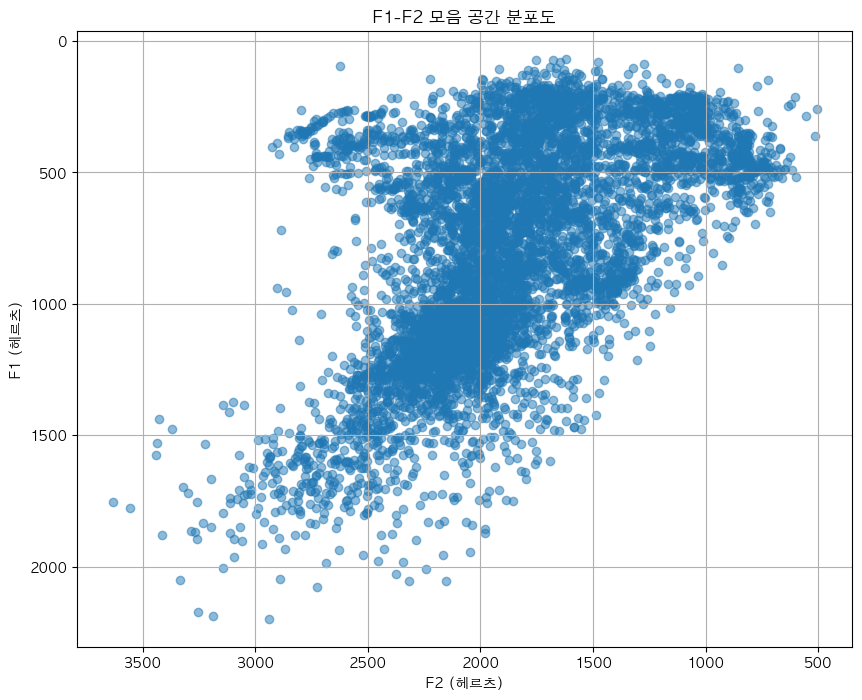

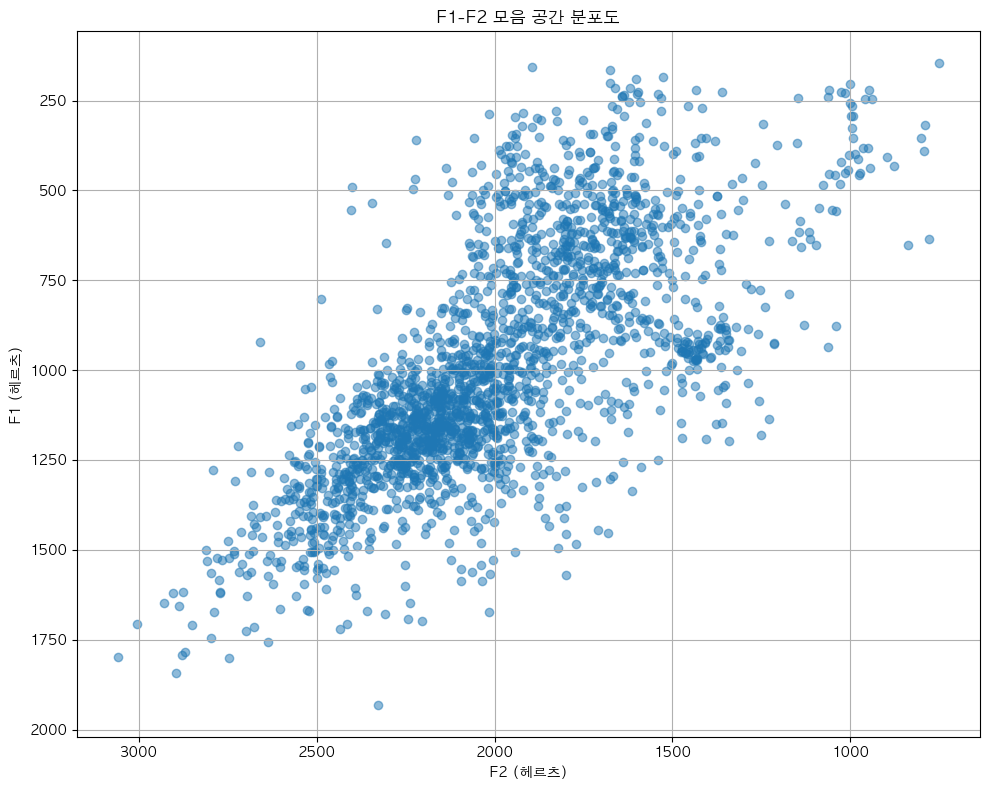

In [2]:
from formant_analysis import analyze_formants
import matplotlib.pyplot as plt

# 전체 figure 생성
fig = plt.figure(figsize=(20, 8))  # 가로 크기를 충분히 확보

# 태박사님 stage 2
wav_file_path = "../../../Desktop/results/participant_9999_20250331_0909/9999_stage2_20250331_0910.wav"
fig, f1_2, f2_2 = analyze_formants(wav_file_path)

# 태박사님 stage 3
wav_file_path = "../../../Desktop/results/participant_9999_20250331_0909/9999_stage3_20250331_0911.wav"
fig, f1_3, f2_3 = analyze_formants(wav_file_path)

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

# 포먼트 값 출력
#print("\nStage 2 포먼트:", f1_2, f2_2)
#print("Stage 3 포먼트:", f1_3, f2_3)

In [2]:
from formant_analysis import analyze_formants
import matplotlib.pyplot as plt
import os

def plot_results(participant_path):
    # 전체 figure 생성
    fig = plt.figure(figsize=(20, 15))  # 3x2 그리드를 위해 세로 크기도 충분히 확보


    wav_files = [f for f in os.listdir(participant_path) if f.endswith('.wav')]

    # 파일 개수 확인 및 정렬
    wav_files.sort()  # 파일 이름 순으로 정렬

    # 각 파일에 대해 서브플롯 생성
    for i, file_path in enumerate(wav_files):
        full_path = os.path.join(participant_path, file_path)
    
        # 행과 열 위치 계산 (3x2 그리드)
        row = i // 2 + 1  # 3행
        col = i % 2 + 1   # 2열
        position = (3, 2, ((row-1)*2 + col))  # (행, 열, 위치)
    
        # 포먼트 분석 및 그래프 그리기
        fig, f1, f2 = analyze_formants(full_path, fig=fig, subplot_position=position)
    
        # 파일 이름을 그래프 제목에 추가
        current_ax = plt.gcf().axes[i]
        current_ax.set_title(f'F1-F2 모음 공간 분포도\n{file_path}')

    # 그래프 레이아웃 조정
    plt.tight_layout()
    plt.show()

시간 0.5초에서의 F1: 1390.4856115341697 Hz, F2: 2176.4425864890413 Hz
시간 0.5초에서의 F1: 1027.4750785949302 Hz, F2: 2034.0374631469394 Hz
시간 0.5초에서의 F1: 685.0686121287108 Hz, F2: 1968.3747967079241 Hz
시간 0.5초에서의 F1: 1557.148074395724 Hz, F2: 2040.78779168911 Hz
시간 0.5초에서의 F1: 1037.356885727781 Hz, F2: 2030.789806085111 Hz
시간 0.5초에서의 F1: 1230.0477161452882 Hz, F2: 2190.144638054852 Hz


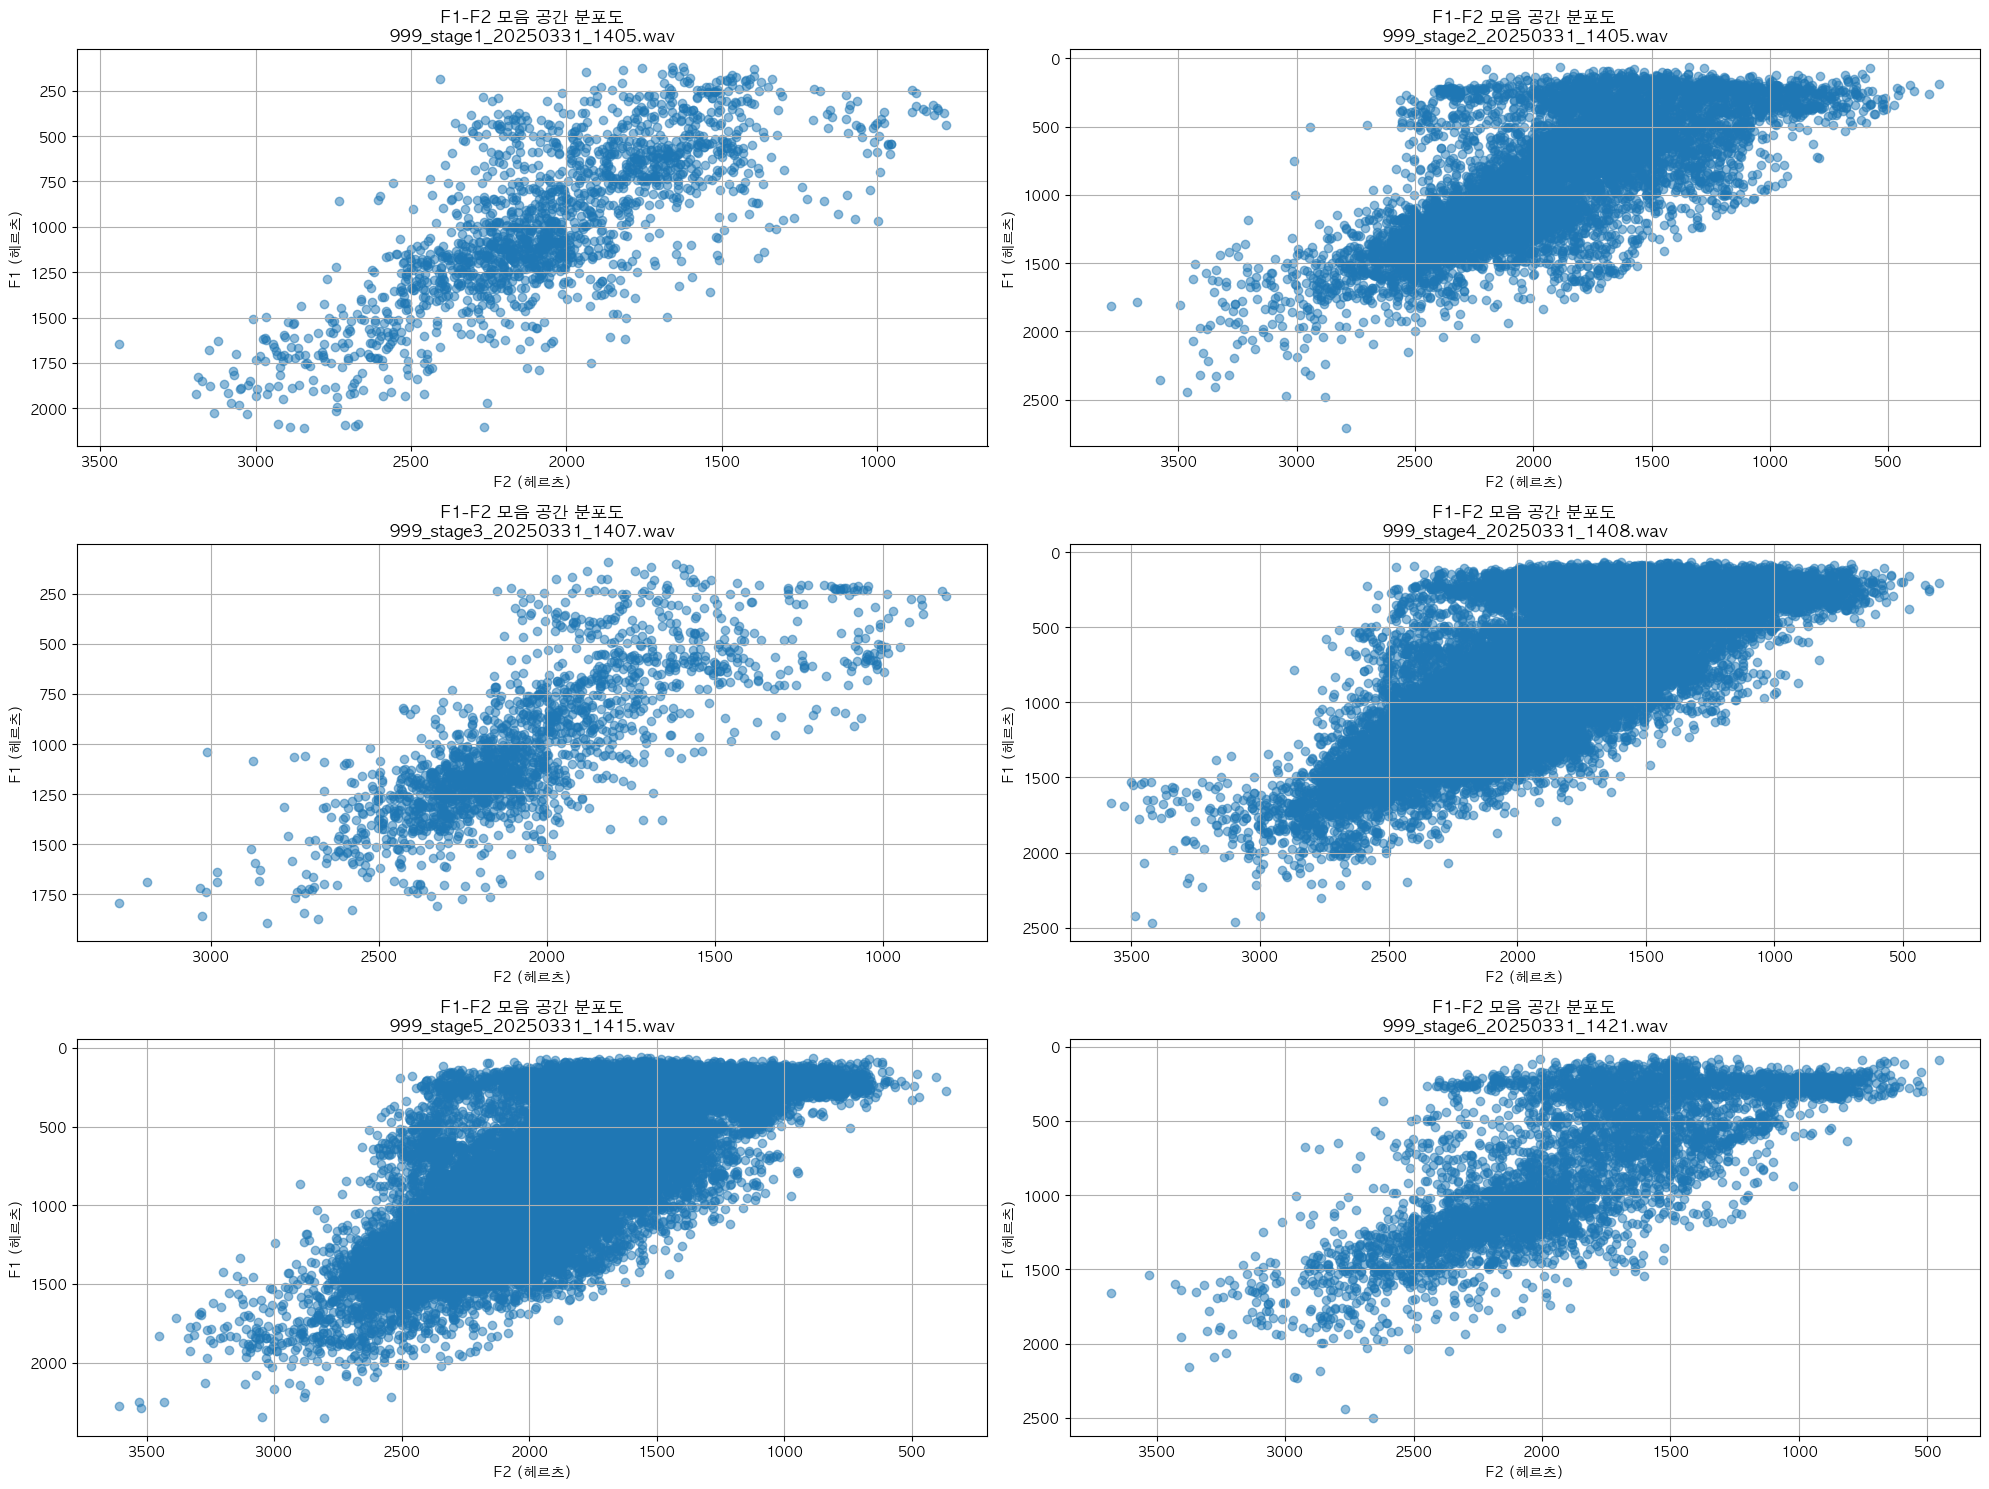

In [3]:
# 강박사님
participant_path_1 = "../../../Desktop/results/participant_999/"
plot_results(participant_path_1)

시간 0.5초에서의 F1: 509.65790223105256 Hz, F2: 1907.454736247784 Hz
시간 0.5초에서의 F1: 436.6161785365898 Hz, F2: 1669.1074148683101 Hz
시간 0.5초에서의 F1: 1268.7425659863575 Hz, F2: 2360.5431768478084 Hz
시간 0.5초에서의 F1: 1172.9026494031327 Hz, F2: 2343.0407760385183 Hz
시간 0.5초에서의 F1: 1899.6858350835128 Hz, F2: 3251.739994706401 Hz
시간 0.5초에서의 F1: 1320.380962394715 Hz, F2: 2253.808909180578 Hz


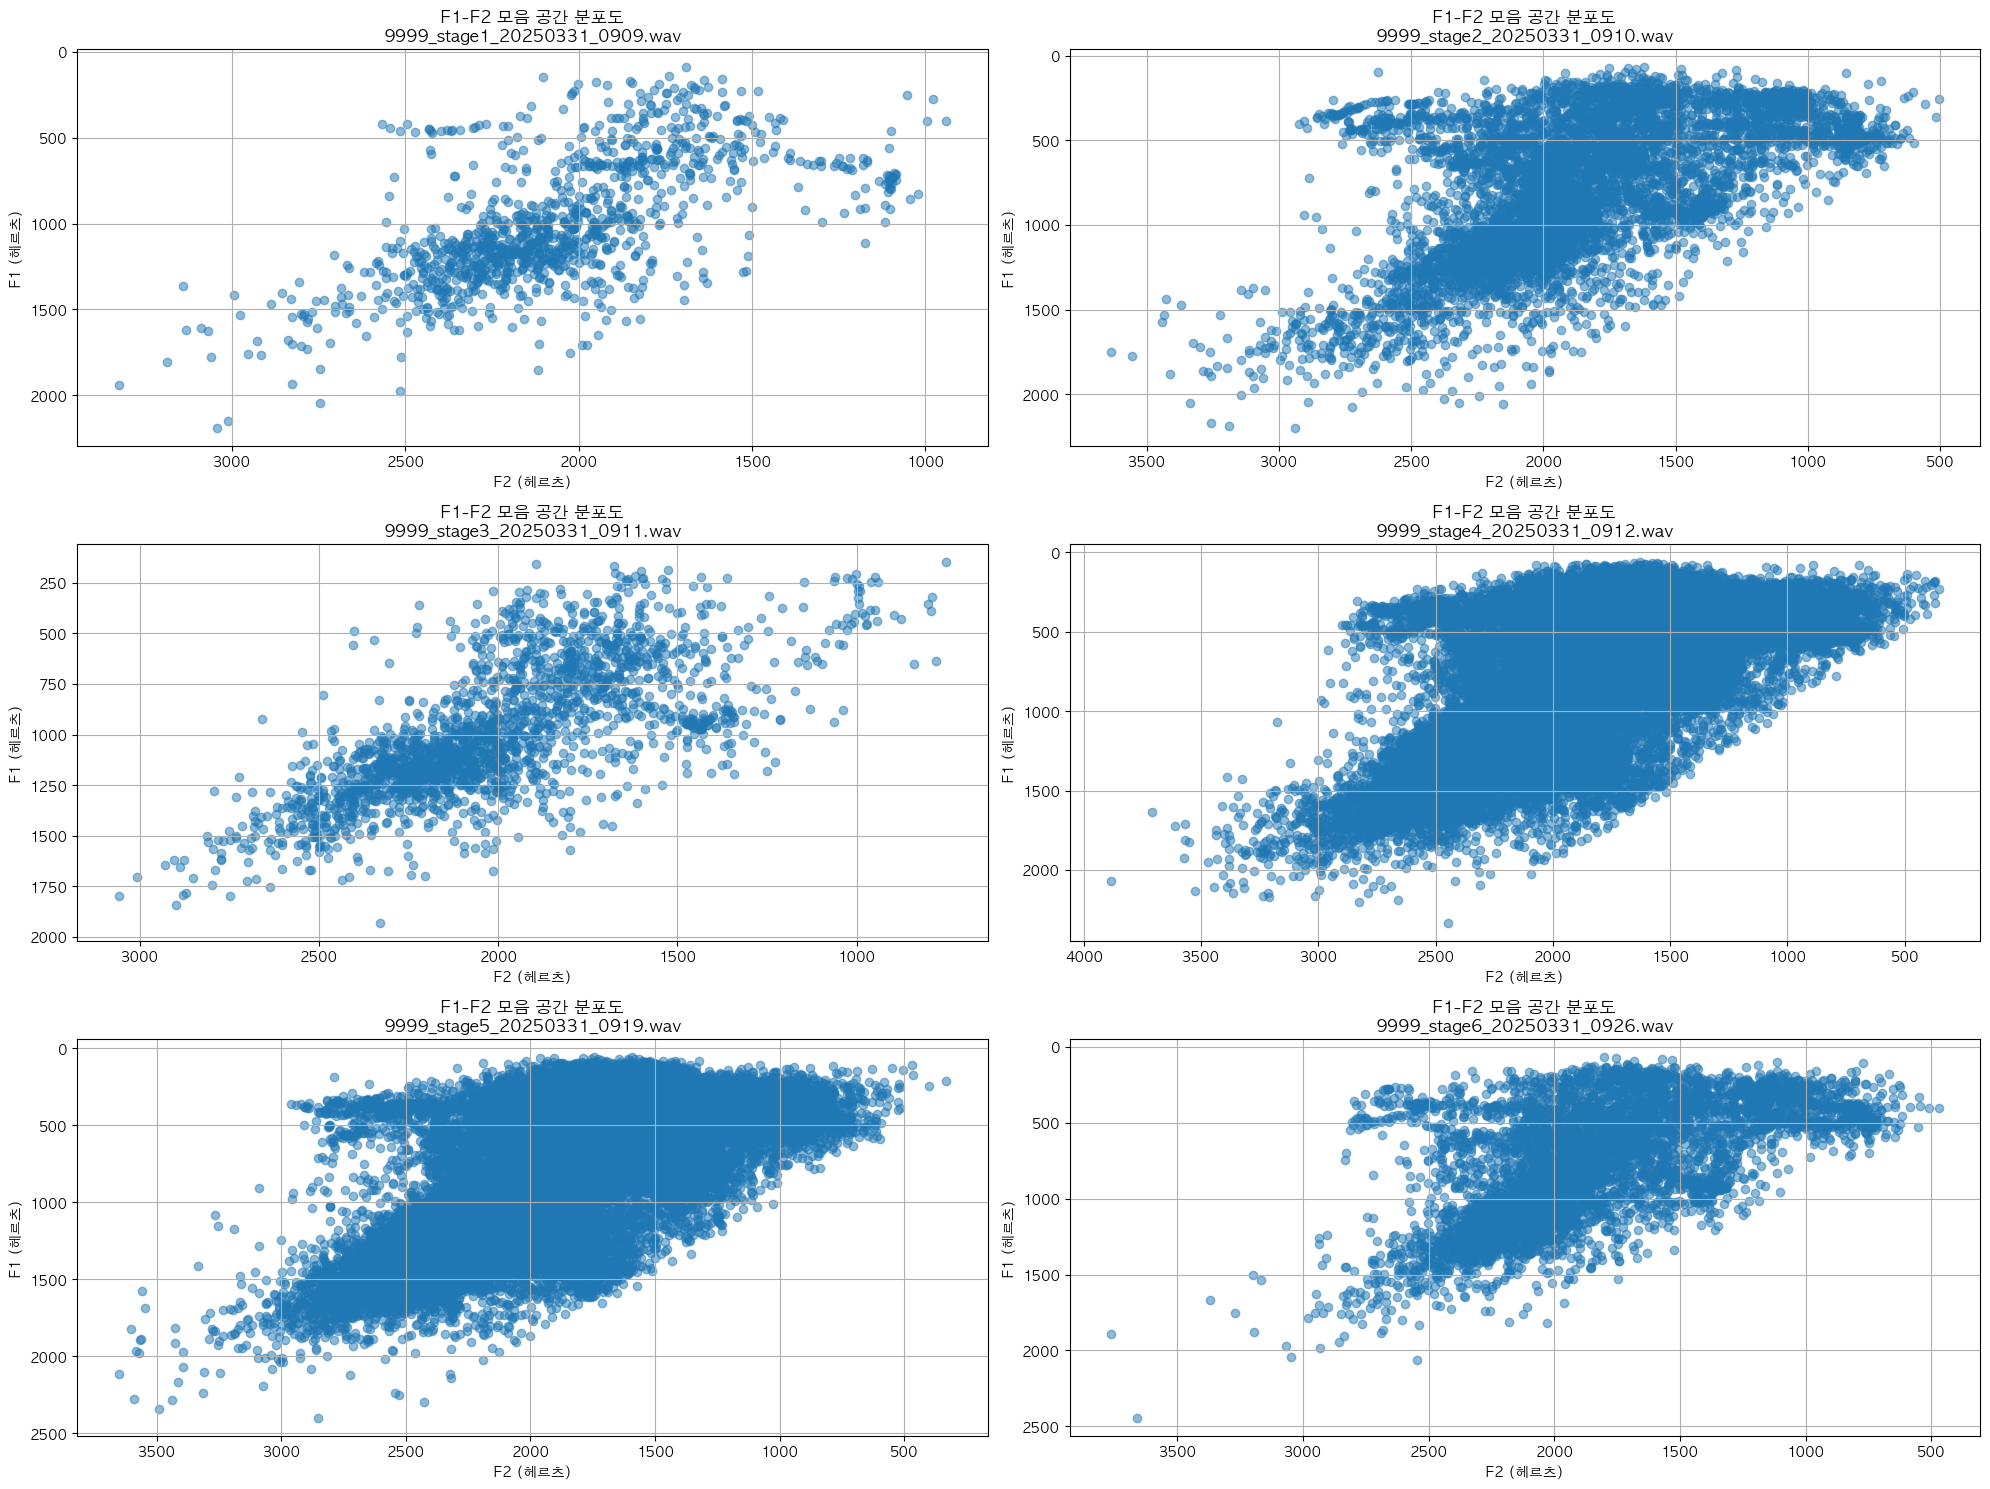

In [4]:
# 태박사님
participant_path_2 = "../../../Desktop/results/participant_9999_20250331_0909"
plot_results(participant_path_2)

파일 분석 시작: ../../../Desktop/results/participant_999/999_stage2_20250331_1405.wav
오디오 로드 완료: 샘플링 레이트 44100Hz
Mel-spectrogram 생성 완료: 8205 프레임
포먼트 분석 완료: 9526 포인트
음소 구분 완료: 84 개의 음소 발견


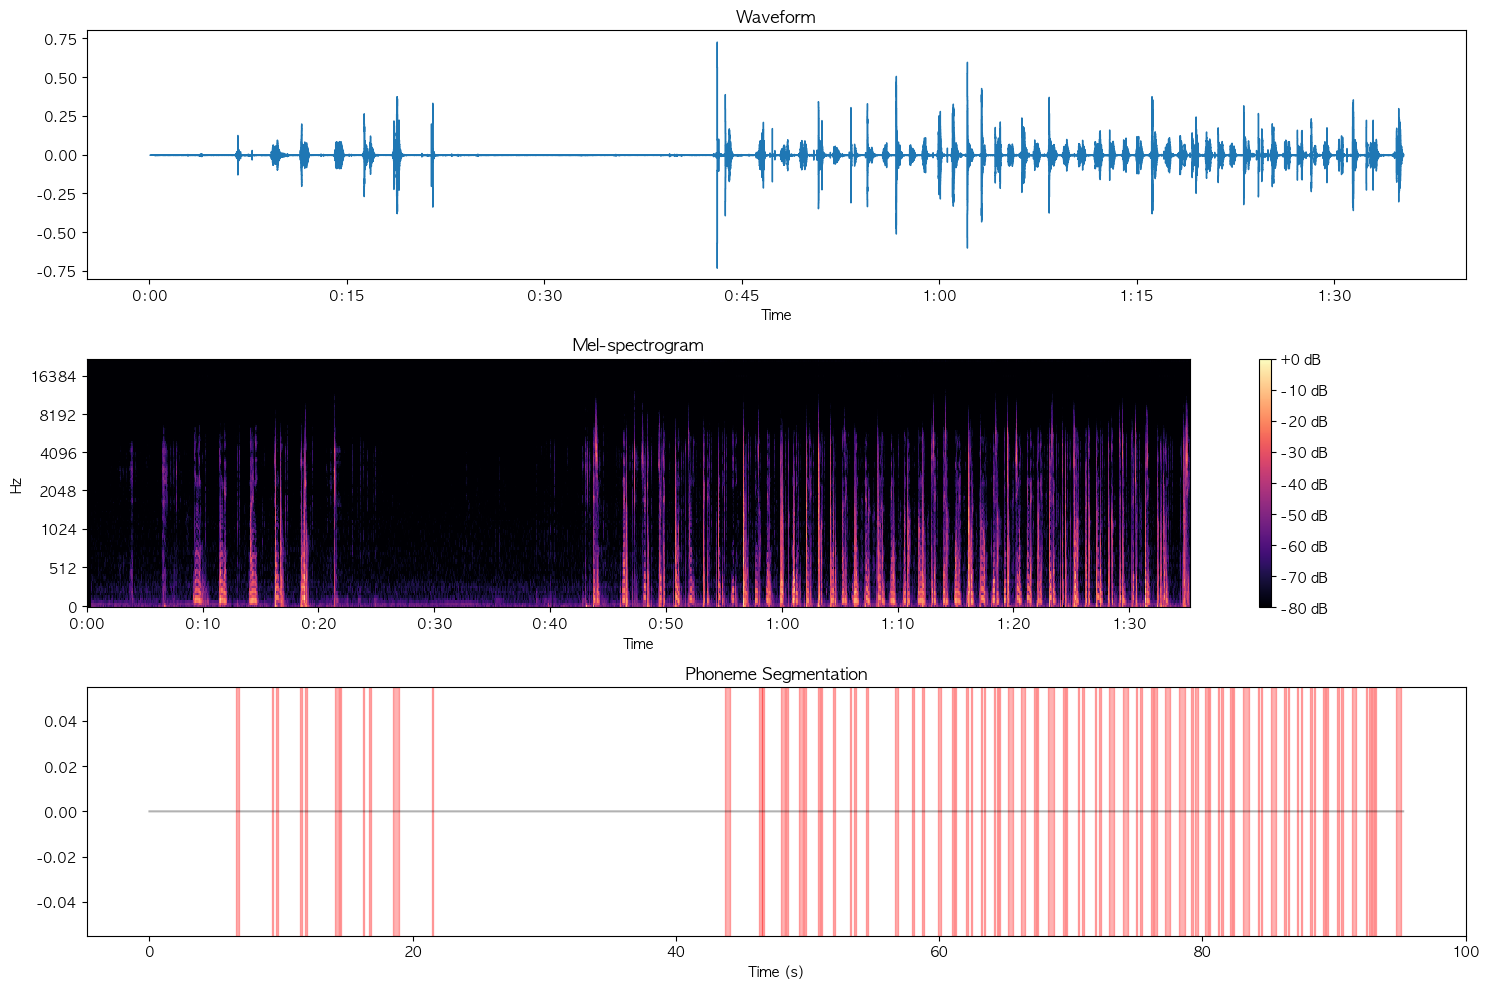


음소 구분 결과:
1. 6.55s - 6.78s: vowel
2. 9.30s - 9.38s: vowel
3. 9.64s - 9.74s: vowel
4. 11.46s - 11.56s: vowel
5. 11.82s - 12.00s: vowel
6. 14.11s - 14.42s: vowel
7. 14.51s - 14.58s: vowel
8. 16.23s - 16.32s: vowel
9. 16.68s - 16.86s: vowel
10. 18.51s - 18.98s: vowel
11. 21.47s - 21.54s: vowel
12. 43.69s - 44.13s: vowel
13. 46.29s - 46.51s: vowel
14. 46.57s - 46.67s: vowel
15. 47.97s - 48.25s: vowel
16. 48.39s - 48.48s: vowel
17. 49.38s - 49.62s: vowel
18. 49.71s - 49.90s: vowel
19. 50.77s - 50.94s: vowel
20. 51.03s - 51.12s: vowel
21. 51.95s - 52.11s: vowel
22. 53.24s - 53.32s: vowel
23. 53.52s - 53.65s: vowel
24. 54.47s - 54.58s: vowel
25. 56.66s - 56.88s: vowel
26. 57.97s - 58.06s: vowel
27. 58.72s - 58.85s: vowel
28. 59.87s - 60.14s: vowel
29. 60.95s - 61.15s: vowel
30. 61.21s - 61.28s: vowel
31. 62.07s - 62.16s: vowel
32. 62.43s - 62.50s: vowel
33. 63.15s - 63.29s: vowel
34. 63.37s - 63.45s: vowel
35. 64.19s - 64.27s: vowel
36. 64.40s - 64.49s: vowel
37. 64.56s - 64.64s: vowel
38. 6

([(6.548027210884354, 6.780226757369615, 'vowel'),
  (9.299591836734693, 9.380861678004536, 'vowel'),
  (9.636281179138322, 9.740770975056689, 'vowel'),
  (11.459047619047618, 11.563537414965987, 'vowel'),
  (11.818956916099774, 12.004716553287983, 'vowel'),
  (14.106122448979592, 14.419591836734694, 'vowel'),
  (14.512471655328799, 14.582131519274377, 'vowel'),
  (16.23074829931973, 16.32362811791383, 'vowel'),
  (16.683537414965986, 16.857687074829933, 'vowel'),
  (18.506303854875284, 18.982312925170067, 'vowel'),
  (21.466848072562357, 21.536507936507938, 'vowel'),
  (43.68834467120181, 44.12952380952381, 'vowel'),
  (46.288979591836735, 46.509569160997735, 'vowel'),
  (46.56761904761905, 46.672108843537416, 'vowel'),
  (47.972426303854874, 48.251065759637186, 'vowel'),
  (48.39038548752834, 48.48326530612245, 'vowel'),
  (49.3772335600907, 49.621043083900226, 'vowel'),
  (49.71392290249433, 49.89968253968254, 'vowel'),
  (50.770430839002266, 50.944580498866216, 'vowel'),
  (51.0258

In [5]:
from phoneme_segmentation import analyze_audio_file
from phoneme_segmentation import play_audio_segment

analyze_audio_file(participant_path_1 + "999_stage2_20250331_1405.wav")

파일 분석 시작: ../../../Desktop/results/participant_999/999_stage2_20250331_1405.wav
오디오 로드 완료: 샘플링 레이트 44100Hz
Mel-spectrogram 생성 완료: 8205 프레임
포먼트 분석 완료: 9526 포인트
음소 구분 완료: 84 개의 음소 발견


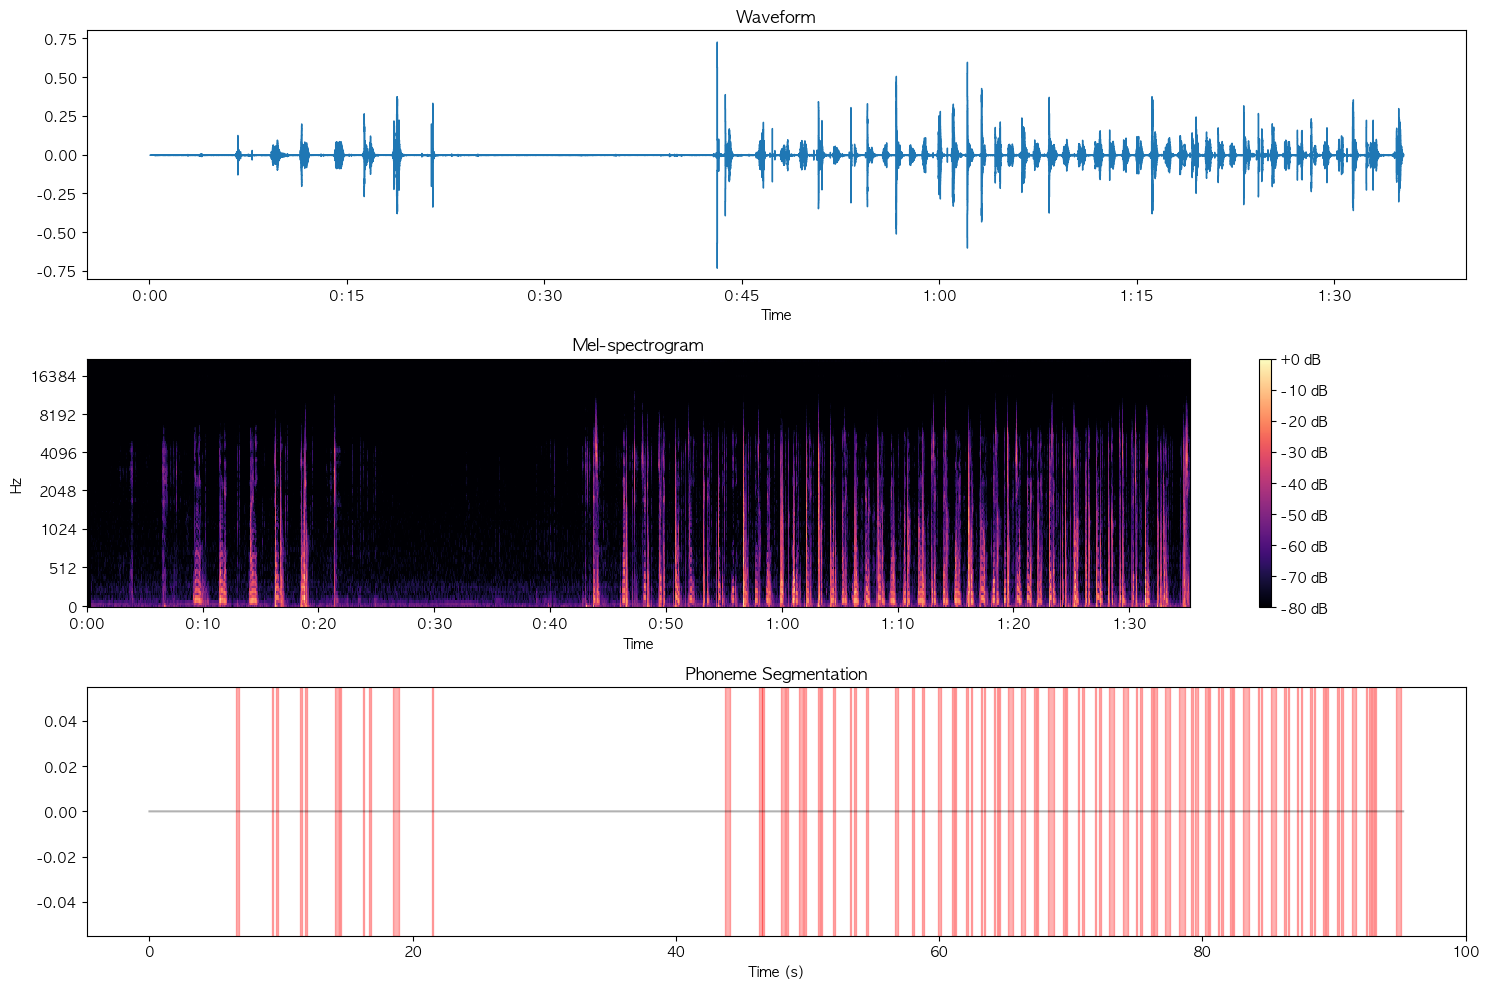


음소 구분 결과:
1. 6.55s - 6.78s: vowel
2. 9.30s - 9.38s: vowel
3. 9.64s - 9.74s: vowel
4. 11.46s - 11.56s: vowel
5. 11.82s - 12.00s: vowel
6. 14.11s - 14.42s: vowel
7. 14.51s - 14.58s: vowel
8. 16.23s - 16.32s: vowel
9. 16.68s - 16.86s: vowel
10. 18.51s - 18.98s: vowel
11. 21.47s - 21.54s: vowel
12. 43.69s - 44.13s: vowel
13. 46.29s - 46.51s: vowel
14. 46.57s - 46.67s: vowel
15. 47.97s - 48.25s: vowel
16. 48.39s - 48.48s: vowel
17. 49.38s - 49.62s: vowel
18. 49.71s - 49.90s: vowel
19. 50.77s - 50.94s: vowel
20. 51.03s - 51.12s: vowel
21. 51.95s - 52.11s: vowel
22. 53.24s - 53.32s: vowel
23. 53.52s - 53.65s: vowel
24. 54.47s - 54.58s: vowel
25. 56.66s - 56.88s: vowel
26. 57.97s - 58.06s: vowel
27. 58.72s - 58.85s: vowel
28. 59.87s - 60.14s: vowel
29. 60.95s - 61.15s: vowel
30. 61.21s - 61.28s: vowel
31. 62.07s - 62.16s: vowel
32. 62.43s - 62.50s: vowel
33. 63.15s - 63.29s: vowel
34. 63.37s - 63.45s: vowel
35. 64.19s - 64.27s: vowel
36. 64.40s - 64.49s: vowel
37. 64.56s - 64.64s: vowel
38. 6

In [10]:
# 음소 분석만 수행
phonemes = analyze_audio_file(participant_path_1 + "999_stage2_20250331_1405.wav")

In [11]:
for start_time, end_time, phoneme_type in phonemes:
    play_audio_segment(y, sr, start_time, end_time)

([(6.548027210884354, 6.780226757369615, 'vowel'),
  (9.299591836734693, 9.380861678004536, 'vowel'),
  (9.636281179138322, 9.740770975056689, 'vowel'),
  (11.459047619047618, 11.563537414965987, 'vowel'),
  (11.818956916099774, 12.004716553287983, 'vowel'),
  (14.106122448979592, 14.419591836734694, 'vowel'),
  (14.512471655328799, 14.582131519274377, 'vowel'),
  (16.23074829931973, 16.32362811791383, 'vowel'),
  (16.683537414965986, 16.857687074829933, 'vowel'),
  (18.506303854875284, 18.982312925170067, 'vowel'),
  (21.466848072562357, 21.536507936507938, 'vowel'),
  (43.68834467120181, 44.12952380952381, 'vowel'),
  (46.288979591836735, 46.509569160997735, 'vowel'),
  (46.56761904761905, 46.672108843537416, 'vowel'),
  (47.972426303854874, 48.251065759637186, 'vowel'),
  (48.39038548752834, 48.48326530612245, 'vowel'),
  (49.3772335600907, 49.621043083900226, 'vowel'),
  (49.71392290249433, 49.89968253968254, 'vowel'),
  (50.770430839002266, 50.944580498866216, 'vowel'),
  (51.0258

In [ ]:
play_audio_segment(y, sr, start_time, end_time)

파일 분석 시작: ../../../Desktop/results/participant_999/999_stage2_20250331_1405.wav
오디오 로드 완료: 샘플링 레이트 44100Hz
Mel-spectrogram 생성 완료: 8205 프레임
포먼트 분석 완료: 9526 포인트
음소 구분 완료: 84 개의 음소 발견


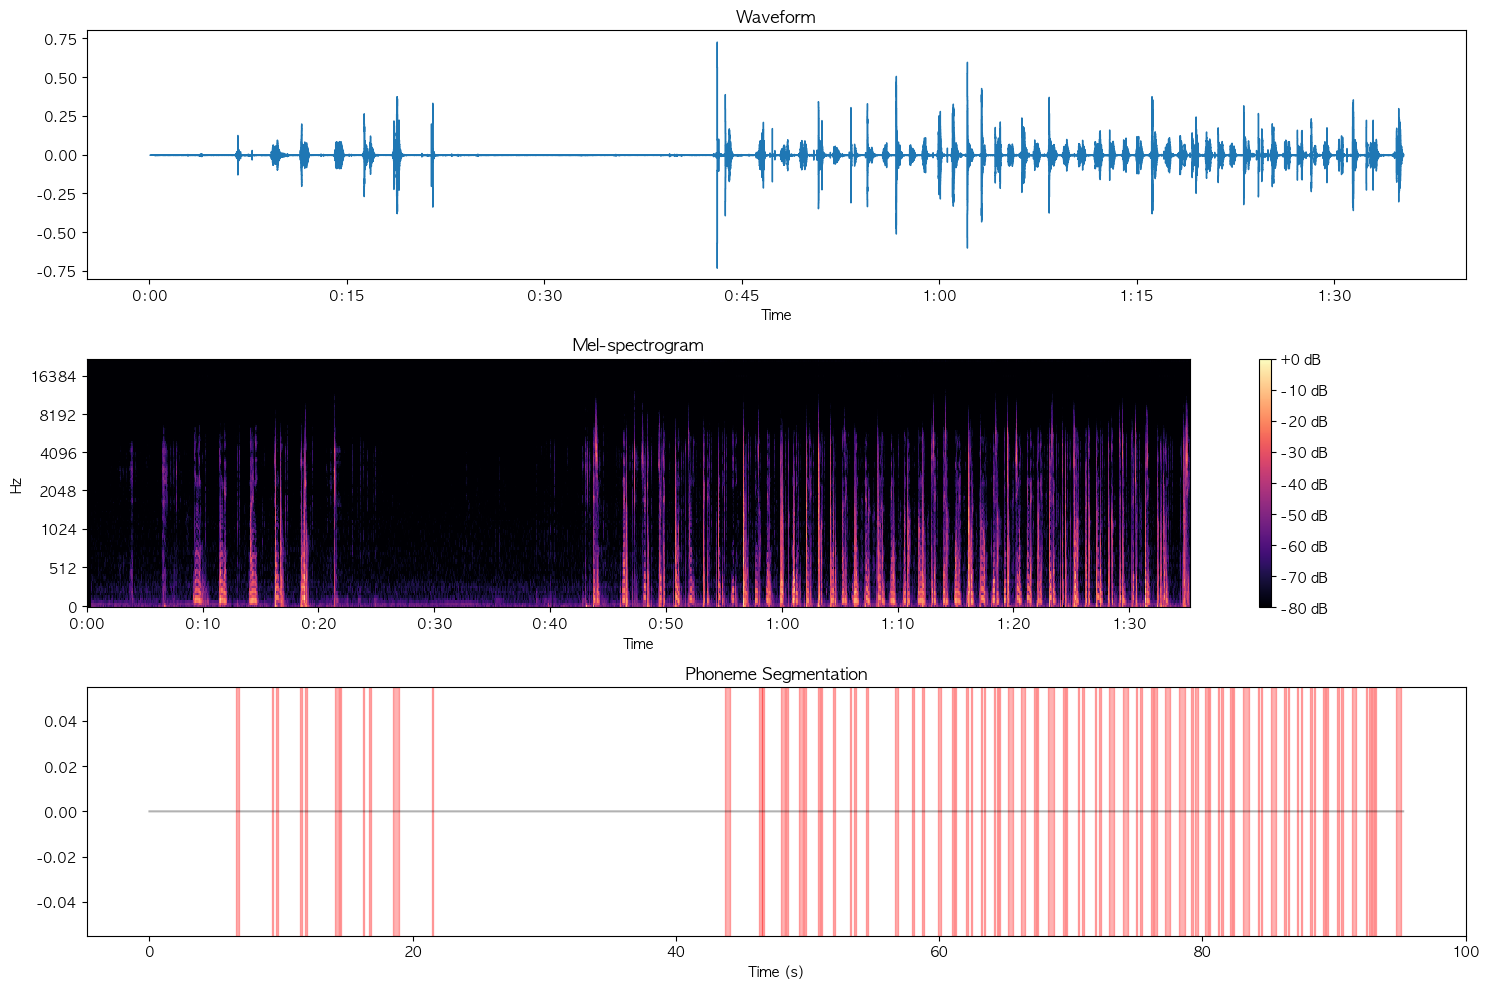


음소 구분 결과:
1. 6.55s - 6.78s: vowel
2. 9.30s - 9.38s: vowel
3. 9.64s - 9.74s: vowel
4. 11.46s - 11.56s: vowel
5. 11.82s - 12.00s: vowel
6. 14.11s - 14.42s: vowel
7. 14.51s - 14.58s: vowel
8. 16.23s - 16.32s: vowel
9. 16.68s - 16.86s: vowel
10. 18.51s - 18.98s: vowel
11. 21.47s - 21.54s: vowel
12. 43.69s - 44.13s: vowel
13. 46.29s - 46.51s: vowel
14. 46.57s - 46.67s: vowel
15. 47.97s - 48.25s: vowel
16. 48.39s - 48.48s: vowel
17. 49.38s - 49.62s: vowel
18. 49.71s - 49.90s: vowel
19. 50.77s - 50.94s: vowel
20. 51.03s - 51.12s: vowel
21. 51.95s - 52.11s: vowel
22. 53.24s - 53.32s: vowel
23. 53.52s - 53.65s: vowel
24. 54.47s - 54.58s: vowel
25. 56.66s - 56.88s: vowel
26. 57.97s - 58.06s: vowel
27. 58.72s - 58.85s: vowel
28. 59.87s - 60.14s: vowel
29. 60.95s - 61.15s: vowel
30. 61.21s - 61.28s: vowel
31. 62.07s - 62.16s: vowel
32. 62.43s - 62.50s: vowel
33. 63.15s - 63.29s: vowel
34. 63.37s - 63.45s: vowel
35. 64.19s - 64.27s: vowel
36. 64.40s - 64.49s: vowel
37. 64.56s - 64.64s: vowel
38. 6

([(6.548027210884354, 6.780226757369615, 'vowel'),
  (9.299591836734693, 9.380861678004536, 'vowel'),
  (9.636281179138322, 9.740770975056689, 'vowel'),
  (11.459047619047618, 11.563537414965987, 'vowel'),
  (11.818956916099774, 12.004716553287983, 'vowel'),
  (14.106122448979592, 14.419591836734694, 'vowel'),
  (14.512471655328799, 14.582131519274377, 'vowel'),
  (16.23074829931973, 16.32362811791383, 'vowel'),
  (16.683537414965986, 16.857687074829933, 'vowel'),
  (18.506303854875284, 18.982312925170067, 'vowel'),
  (21.466848072562357, 21.536507936507938, 'vowel'),
  (43.68834467120181, 44.12952380952381, 'vowel'),
  (46.288979591836735, 46.509569160997735, 'vowel'),
  (46.56761904761905, 46.672108843537416, 'vowel'),
  (47.972426303854874, 48.251065759637186, 'vowel'),
  (48.39038548752834, 48.48326530612245, 'vowel'),
  (49.3772335600907, 49.621043083900226, 'vowel'),
  (49.71392290249433, 49.89968253968254, 'vowel'),
  (50.770430839002266, 50.944580498866216, 'vowel'),
  (51.0258

In [14]:
# 특정 음소 재생
analyze_audio_file(participant_path_1 + "999_stage2_20250331_1405.wav", phoneme_number=10)  # 첫 번째 음소 재생